In [111]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import rbf_kernel
try:    
    import statsmodels.api as sm
except ImportError:
    !pip install statsmodels
    import statsmodels.api as sm


In [159]:
data_5 = pd.read_csv('data/data5.csv')
data_80 = pd.read_csv('data/data80.csv')
data_5.describe()


,value
count,5001.000000
mean,56.150333
std,21.340006
min,5.000000
25%,39.575868
50%,61.876776
75%,73.047143
max,94.664012


In [160]:

def mmd_statistic(X, Y, gamma=None):
    """Calculate the MMD statistic between two samples X and Y using RBF kernel"""
    XX = rbf_kernel(X, X, gamma)
    YY = rbf_kernel(Y, Y, gamma)
    XY = rbf_kernel(X, Y, gamma)
    
    n = X.shape[0]
    m = Y.shape[0]
    
    # Calculate MMD^2
    mmd_squared = (np.sum(XX) - np.trace(XX)) / (n * (n - 1))
    mmd_squared += (np.sum(YY) - np.trace(YY)) / (m * (m - 1))
    mmd_squared -= 2 * np.sum(XY) / (n * m)
    
    return np.sqrt(max(mmd_squared, 0))  # Return MMD (not squared)


In [161]:

def detect_change_points(time_series, window_size, stride=1, threshold=None,plot = True):
    """
    Detect change points using the sliding window approach with MMD.
    
    Parameters:
    - time_series: 1D numpy array
    - window_size: Size of each window
    - stride: How many steps to move the window each time
    - threshold: Threshold for detecting a change point. If None, will be estimated.
    
    Returns:
    - List of detected change point indices
    """
    # Reshape 1D series to 2D if needed
    if len(time_series.shape) == 1:
        time_series = time_series.reshape(-1, 1)
    
    n_samples = time_series.shape[0]
    mmd_scores = []
    gamma = None
    # Calculate MMD scores for each potential change point
    for i in range(window_size, n_samples - window_size + 1, stride):
        window_before = time_series[i - window_size:i]
        window_after = time_series[i:i + window_size]
        
        # Use median heuristic for kernel bandwidth if not specified
        if not gamma:
            X = np.vstack([window_before, window_after])
            dists = rbf_kernel(X, X)
            gamma = 1.0 /  np.median(dists[dists > 0])
        
        score = mmd_statistic(window_before, window_after, gamma)
        mmd_scores.append((i, score))
    
    scores = [score for _, score in mmd_scores]
    
    threshold = np.mean(scores) + 2 * np.std(scores)
    # threshold = np.percentile(mmd_scores[1], 90)   
    print("threshold",threshold)
    
    # Find change points based on threshold
    change_points = [idx for (idx, score)in mmd_scores if score > threshold]
    # Debug information
    print(f"Number of MMD scores calculated: {len(mmd_scores)}")
    print(f"Threshold value: {threshold}")
    print(f"Number of change points detected: {len(change_points)}")
    
    # If no change points were detected, provide additional information
    if len(change_points) == 0:
        print("No change points detected. Consider adjusting the threshold or window size.")
    if plot:
        # Print some statistics about the MMD scores
        scores_array = np.array([score for _, score in mmd_scores])
        print("MMD scores statistics:")
        print(f"  Min: {scores_array.min():.4f}")
        print(f"  Max: {scores_array.max():.4f}")
        print(f"  Mean: {scores_array.mean():.4f}")
        print(f"  Std: {scores_array.std():.4f}")
        print(f"  90th percentile: {np.percentile(scores_array, 90):.4f}")
        # Extract scores from mmd_scores tuples
        scores = [score for _, score in mmd_scores]
        
        # Create histogram of MMD scores
        plt.figure(figsize=(10, 6))
        plt.hist(scores, bins=30, alpha=0.7, color='skyblue')
        plt.title('Histogram of MMD Scores')
        plt.xlabel('MMD Score')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        plt.show()
    return change_points, mmd_scores, threshold


threshold 1.185909974652934
Number of MMD scores calculated: 4986
Threshold value: 1.185909974652934
Number of change points detected: 21
MMD scores statistics:
  Min: 0.0000
  Max: 1.2830
  Mean: 0.5031
  Std: 0.3414
  90th percentile: 0.9666


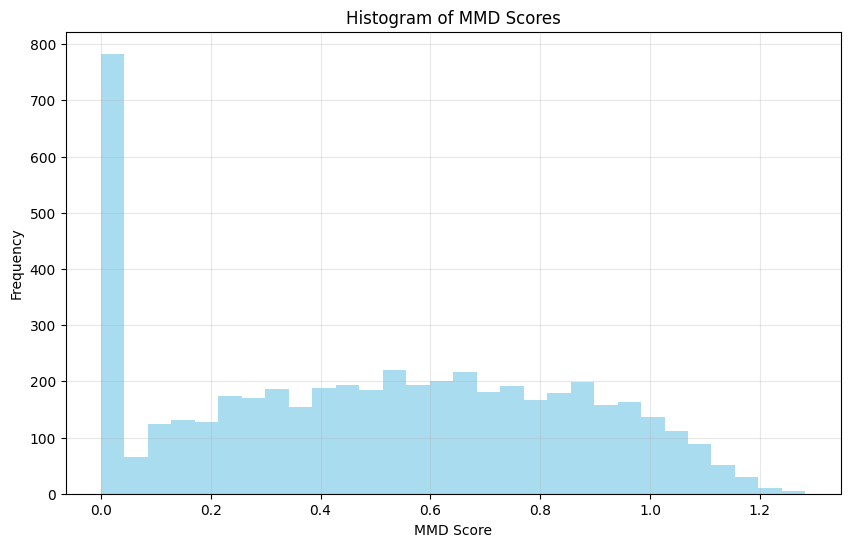

threshold 1.1638805657234403
Number of MMD scores calculated: 4992
Threshold value: 1.1638805657234403
Number of change points detected: 39
MMD scores statistics:
  Min: 0.0000
  Max: 1.2614
  Mean: 0.4615
  Std: 0.3512
  90th percentile: 0.9421


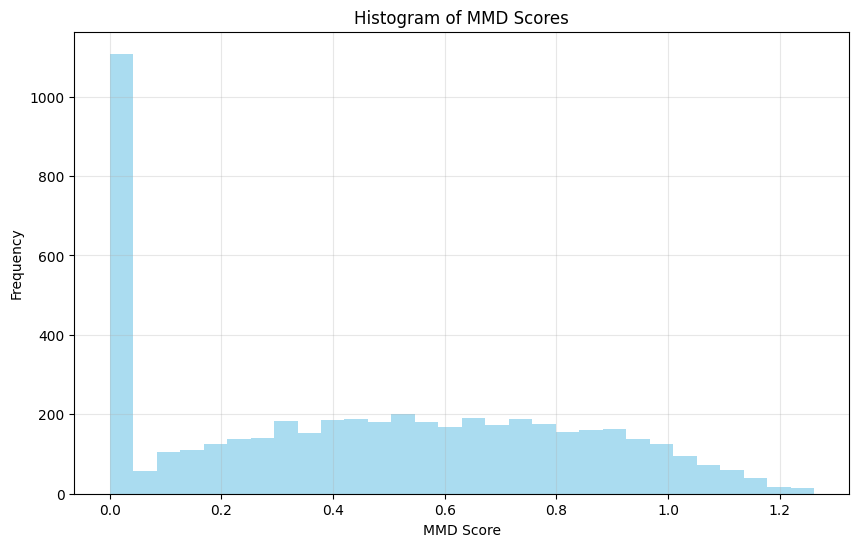

change_points5 [887, 1311, 1946, 1947, 2304, 2356, 2386, 2511, 2522, 3532, 3564, 3576, 3675, 3676, 4200, 4302, 4469, 4803, 4855, 4856, 4977]
change_points80 [299, 304, 637, 899, 953, 1171, 1178, 1374, 1382, 1466, 1471, 1565, 1627, 1666, 1729, 1757, 1777, 1834, 1882, 2087, 2173, 2457, 2749, 3029, 3152, 3244, 3415, 3526, 3933, 4198, 4313, 4320, 4355, 4368, 4387, 4550, 4661, 4738, 4796]
threshold 0.9748936047287322
Number of MMD scores calculated: 4996
Threshold value: 0.9748936047287322
Number of change points detected: 155
MMD scores statistics:
  Min: 0.0000
  Max: 1.2922
  Mean: 0.3425
  Std: 0.3162
  90th percentile: 0.8045


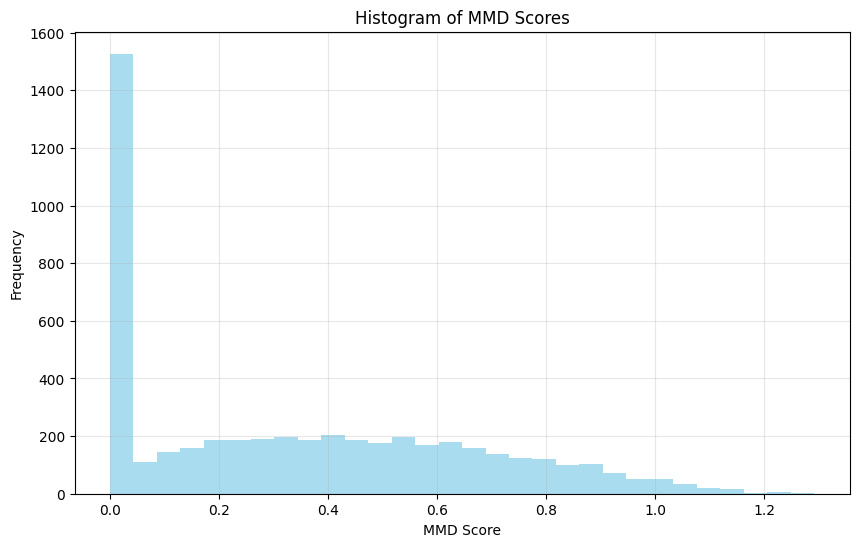

threshold 1.104560299113333
Number of MMD scores calculated: 4996
Threshold value: 1.104560299113333
Number of change points detected: 126
MMD scores statistics:
  Min: 0.0000
  Max: 1.2973
  Mean: 0.3922
  Std: 0.3562
  90th percentile: 0.8971


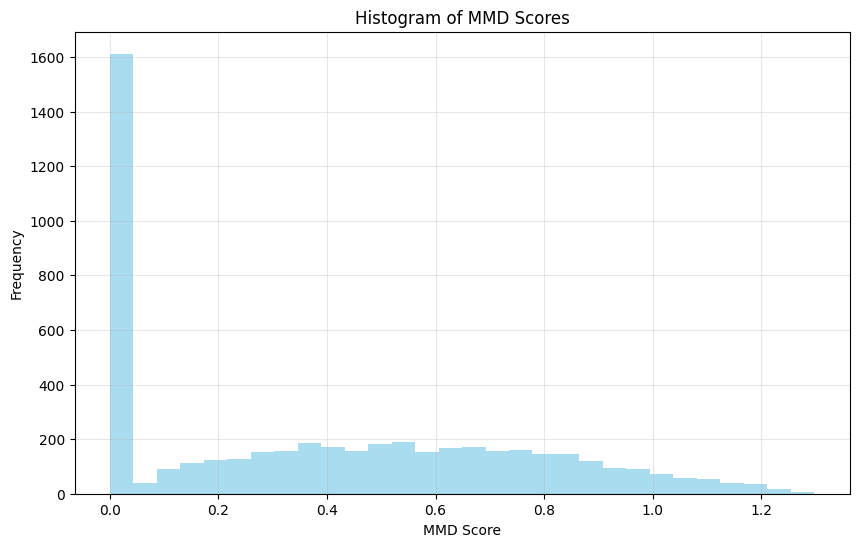

change_points5 [337, 472, 639, 776, 801, 956, 989, 1008, 1081, 1090, 1129, 1139, 1178, 1230, 1247, 1275, 1303, 1311, 1380, 1393, 1394, 1686, 1757, 1811, 1814, 1862, 1895, 1946, 1947, 1973, 2010, 2167, 2304, 2339, 2340, 2356, 2386, 2451, 2512, 2522, 2574, 2575, 2618, 2639, 2670, 2671, 2707, 2712, 2759, 2761, 2789, 2859, 2910, 2913, 2937, 2964, 2971, 2993, 3021, 3032, 3044, 3071, 3072, 3077, 3081, 3098, 3099, 3104, 3107, 3137, 3171, 3192, 3196, 3203, 3207, 3228, 3234, 3235, 3249, 3271, 3272, 3283, 3297, 3315, 3336, 3337, 3358, 3372, 3385, 3401, 3443, 3466, 3474, 3501, 3512, 3532, 3563, 3564, 3576, 3616, 3617, 3623, 3631, 3641, 3675, 3703, 3734, 3757, 3777, 3792, 3908, 3936, 4003, 4011, 4095, 4200, 4234, 4235, 4242, 4266, 4282, 4301, 4302, 4303, 4354, 4355, 4390, 4408, 4437, 4441, 4442, 4469, 4516, 4540, 4553, 4564, 4640, 4651, 4661, 4668, 4694, 4701, 4751, 4768, 4794, 4803, 4835, 4855, 4856, 4876, 4879, 4919, 4933, 4936, 4977]
change_points80 [55, 194, 299, 304, 311, 573, 583, 587, 637, 

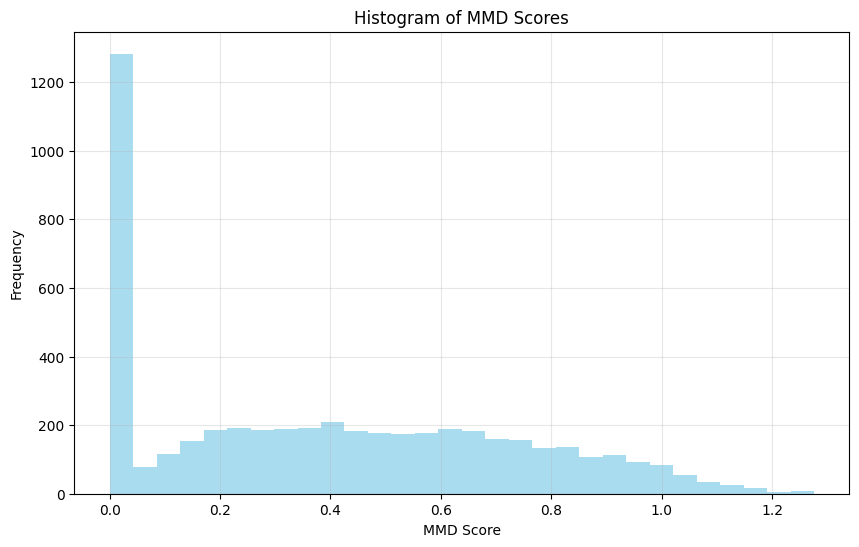

threshold 1.1284813497137052
Number of MMD scores calculated: 4994
Threshold value: 1.1284813497137052
Number of change points detected: 72
MMD scores statistics:
  Min: 0.0000
  Max: 1.3040
  Mean: 0.4265
  Std: 0.3510
  90th percentile: 0.9135


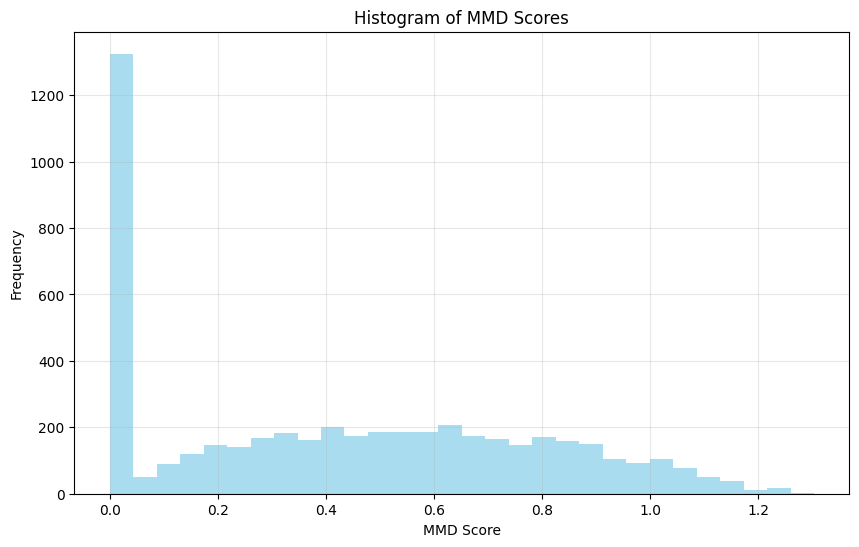

change_points5 [337, 639, 776, 956, 1178, 1230, 1275, 1303, 1311, 1393, 1394, 1757, 1946, 1947, 2130, 2304, 2340, 2356, 2386, 2451, 2511, 2512, 2522, 2574, 2575, 2670, 2671, 2707, 2761, 2789, 2913, 2937, 2993, 3021, 3044, 3071, 3072, 3077, 3098, 3099, 3107, 3137, 3196, 3207, 3228, 3234, 3249, 3271, 3272, 3297, 3315, 3336, 3358, 3372, 3443, 3466, 3532, 3563, 3564, 3576, 3617, 3623, 3641, 3675, 3734, 3757, 3777, 3908, 4003, 4011, 4095, 4200, 4234, 4242, 4266, 4282, 4301, 4302, 4354, 4355, 4390, 4408, 4437, 4441, 4442, 4469, 4516, 4553, 4564, 4640, 4661, 4694, 4751, 4794, 4803, 4835, 4855, 4879, 4919, 4933, 4977]
change_points80 [194, 299, 304, 492, 573, 583, 637, 785, 899, 953, 1097, 1171, 1178, 1338, 1373, 1374, 1382, 1418, 1466, 1471, 1565, 1627, 1666, 1729, 1757, 1777, 1834, 1882, 1951, 1955, 1977, 2000, 2086, 2087, 2173, 2418, 2457, 2668, 2679, 2749, 2892, 2913, 2936, 3011, 3023, 3029, 3079, 3141, 3152, 3308, 3415, 3519, 3526, 3600, 3933, 3982, 3999, 4177, 4198, 4259, 4293, 4313, 432

In [162]:

change_points5,mmd_scores5,threshold5 = detect_change_points(data_5,8)
change_points80,mmd_scores80,threshold80 = detect_change_points(data_80,5)
print('change_points5',change_points5)
print('change_points80',change_points80)

change_points5,mmd_scores5,threshold5 = detect_change_points(data_5,3)
change_points80,mmd_scores80,threshold80 = detect_change_points(data_80,3)
print('change_points5',change_points5)
print('change_points80',change_points80)

change_points5,mmd_scores5,threshold5 = detect_change_points(data_5,4)
change_points80,mmd_scores80,threshold80 = detect_change_points(data_80,4)
print('change_points5',change_points5)
print('change_points80',change_points80)

In [136]:
def prediction(data,window_size):
    change_points, mmd_scores, threshold = detect_change_points(data, window_size,plot=False)
    
    
    data['time_index'] = range(len(data))
    data['change_point'] = 0
    
    for i in change_points:
        data.loc[i, 'change_point'] = 1
    print(len(data[data['change_point']==1]))
    print(change_points)
    window_before = data[0:window_size]
    window_before_X = window_before['time_index']
    window_before_Y = window_before['value']
    j = 0
    interval =len(data)//window_size
    for i in range(interval - 1):
        for j in range(len(change_points)):
            if change_points[j] in range(i*window_size,(i+1)*window_size):
            
                windowX = data[i*window_size:(i+1)*window_size]['time_index']
                windowY = data[i*window_size:(i+1)*window_size]['value']
                X = sm.add_constant(windowX)
                model = sm.OLS(windowY, X).fit()    
                # Generate predictions for the next window
                X_next = sm.add_constant(data['time_index'][(1+i)*window_size:(2+i)*window_size])
                
                # Ensure the prediction column exists before assigning values
                if 'prediction' not in data.columns:
                    data['prediction'] = np.nan
                # Use try-except to handle potential shape mismatch errors
                try:
                    data.loc[(1+i)*window_size:(2+i)*window_size-1, 'prediction'] = model.predict(X_next)
                except ValueError as e:
                    print(f"Prediction error: {e}")
                    # Alternative approach using direct indexing if shapes don't align
                    predictions = model.predict(sm.add_constant(data.loc[(1+i)*window_size:(2+i)*window_size-1, 'time_index']))
                    data.loc[(1+i)*window_size:(2+i)*window_size-1, 'prediction'] = predictions

                j += 1
                window_before = data[i*window_size:(i+1)*window_size]
            else:
                # Concatenate the previous window with the current window
                window_before = pd.concat([window_before, data[i*window_size:(i+1)*window_size]])
                window_before_X = window_before['time_index']
                window_before_Y = window_before['value']
                X = sm.add_constant(window_before_X)
                model = sm.OLS(window_before_Y, X).fit()
                x_predict = data['time_index'][(1+i)*window_size:(2+i)*window_size]
                x_predict = sm.add_constant(x_predict)
                data.loc[(1+i)*window_size:(2+i)*window_size-1, 'prediction'] = model.predict(x_predict)

    return data




In [165]:
def plot(data,changepoints=True):
    """
    Visualize time series data with predictions and change points
    
    Parameters:
        data: DataFrame containing time_index, value, prediction, and change_point columns
    """
    # Create a high-resolution figure with improved aesthetics
    plt.figure(figsize=(10, 6), dpi=100, facecolor='#f8f9fa')
    
    # Plot actual data with enhanced styling
    plt.plot(data['time_index'], data['value'], 
             label='Actual Data', 
             color='#1f77b4',  # More vibrant blue
             linewidth=2,
             alpha=0.9)
    
    # Plot predictions with distinct styling
    plt.plot(data['time_index'], data['prediction'], 
             label='Prediction', 
             color='#ff7f0e',  # Bright orange
             linestyle='--',
             linewidth=2,
             alpha=0.8)

    # Highlight change points with more visibility
    change_points = data[data['change_point'] == 1]
    
    if changepoints:
        # Add vertical lines and annotations at change points
        for idx, point in change_points.iterrows():
            plt.axvline(x=point['time_index'], 
                    color='#2ca02c',  # Brighter green
                    linestyle='-',
                    linewidth=1.5,
                    alpha=0.8, 
                    label='Change Point' if idx == change_points.index[0] else '')
            
      
    # Enhanced title and labels
    plt.title('Time Series Analysis with Change Point Detection', 
              fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Time Index', fontsize=12, labelpad=10)
    plt.ylabel('Value', fontsize=12, labelpad=10)
    
    # Improved legend
    plt.legend(loc='best', frameon=True, framealpha=0.9, 
               fancybox=True, shadow=True, fontsize=10)
    
    # Enhanced grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add subtle background shading for change point regions
    for idx, point in change_points.iterrows():
        plt.axvspan(point['time_index'] - 5, point['time_index'] + 5, 
                   color='#2ca02c', alpha=0.1)
    
    plt.tight_layout()
    plt.show()

In [152]:
def plot_deviation_with_change_points(data, dataset_name):
    """
    Plot the deviation between predicted and actual values with change points marked as vertical lines
    
    Parameters:
        data: DataFrame containing 'time_index', 'prediction', 'value', and 'change_point' columns
        dataset_name: Name of the dataset for the plot title
    """
    plt.figure(figsize=(10, 6))
    
    # Calculate deviation (absolute difference between actual and predicted values)
    data['deviation'] = np.abs(data['prediction'] - data['value'])
    
    # Plot the deviation
    plt.plot(data['time_index'], data['deviation'], color='blue', label='Absolute Deviation')
    
    # Mark change points with vertical lines
    change_points = data[data['change_point'] == 1]
    for idx, point in change_points.iterrows():
        plt.axvline(x=point['time_index'], color='red', linestyle='--', alpha=0.7, 
                    label='Change Point' if idx == change_points.index[0] else '')
    
    plt.title(f'Prediction Deviation with Change Points - {dataset_name}')
    plt.xlabel('Time Index')
    plt.ylabel('Absolute Deviation')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [151]:

# Try different window size
window_size1 = 8
window_size2 = 5    
data_5 = pd.read_csv('data/data5.csv')
data_80 = pd.read_csv('data/data80.csv')
data_51 = prediction(data_5,window_size1)
data_51.to_csv('data/data_5_prediction_window_size_8.csv', index=False)
data_801 = prediction(data_80,window_size2)
data_801.to_csv('data/data_80_prediction_window_size_5.csv', index=False)



threshold 1.185909974652934
Number of MMD scores calculated: 4986
Threshold value: 1.185909974652934
Number of change points detected: 21
21
[887, 1311, 1946, 1947, 2304, 2356, 2386, 2511, 2522, 3532, 3564, 3576, 3675, 3676, 4200, 4302, 4469, 4803, 4855, 4856, 4977]
threshold 1.1638805657234403
Number of MMD scores calculated: 4992
Threshold value: 1.1638805657234403
Number of change points detected: 39
39
[299, 304, 637, 899, 953, 1171, 1178, 1374, 1382, 1466, 1471, 1565, 1627, 1666, 1729, 1757, 1777, 1834, 1882, 2087, 2173, 2457, 2749, 3029, 3152, 3244, 3415, 3526, 3933, 4198, 4313, 4320, 4355, 4368, 4387, 4550, 4661, 4738, 4796]


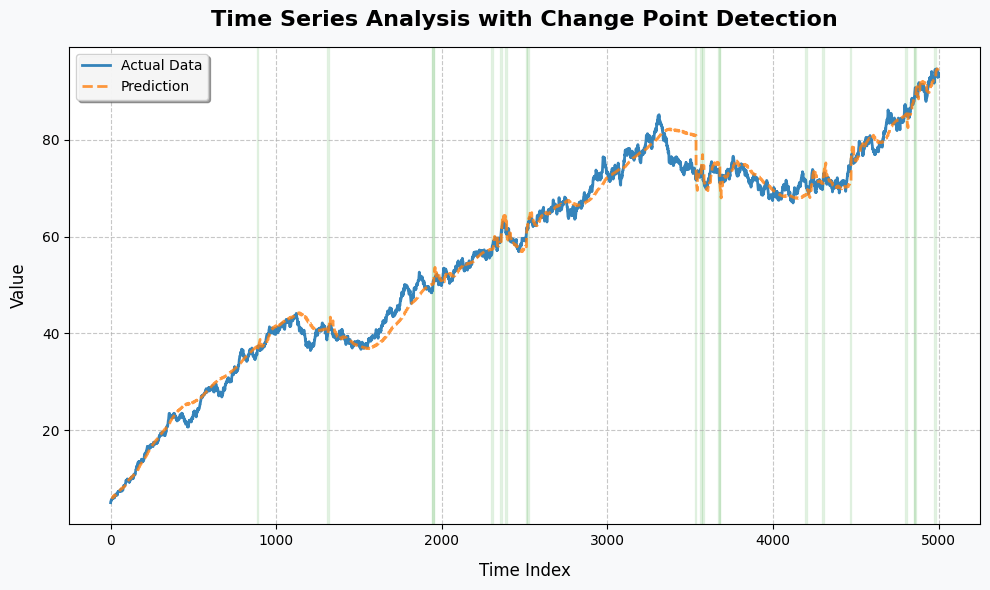

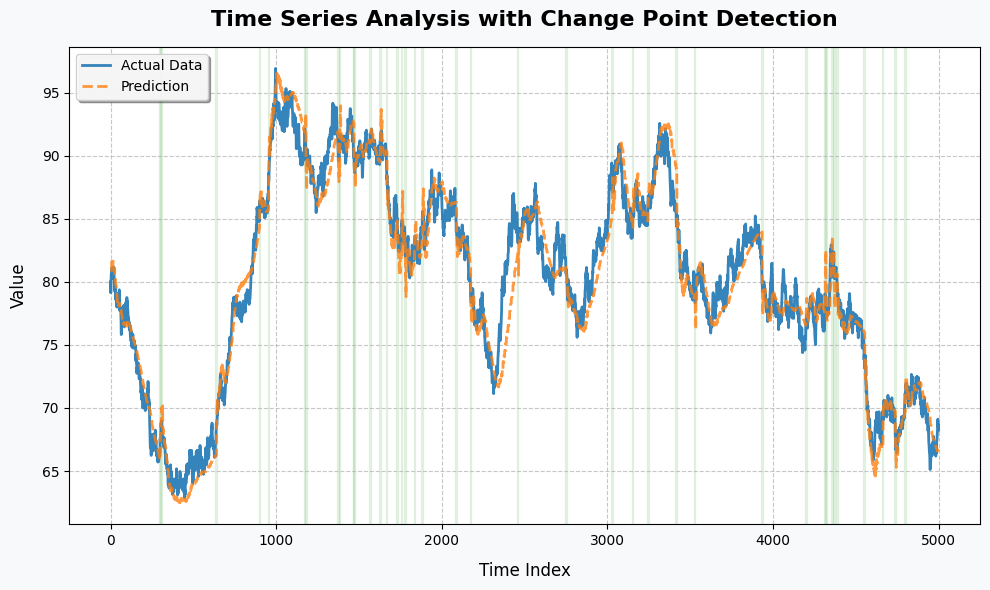

========report========
window_size for data_5 8
window_size for data_80 5
data_5 count    4992.000000
mean       56.380355
std        21.272664
min         5.776691
25%        39.496750
50%        62.445118
75%        73.224718
max        94.731609
Name: prediction, dtype: float64
data_80              value   time_index  change_point   prediction
count  5001.000000  5001.000000   5001.000000  4995.000000
mean     80.128728  2500.000000      0.007798    79.946832
std       7.686935  1443.808678      0.087973     7.952130
min      62.902754     0.000000      0.000000    62.495221
25%      76.321382  1250.000000      0.000000    76.224701
50%      80.499745  2500.000000      0.000000    79.995005
75%      85.615230  3750.000000      0.000000    85.974443
max      96.904312  5000.000000      1.000000    96.550569
mse for data_5 4.605405787292513
mse for data_80 2.821925285888188
std for data_5 21.27053326907504
std for data_80 7.951334332592656


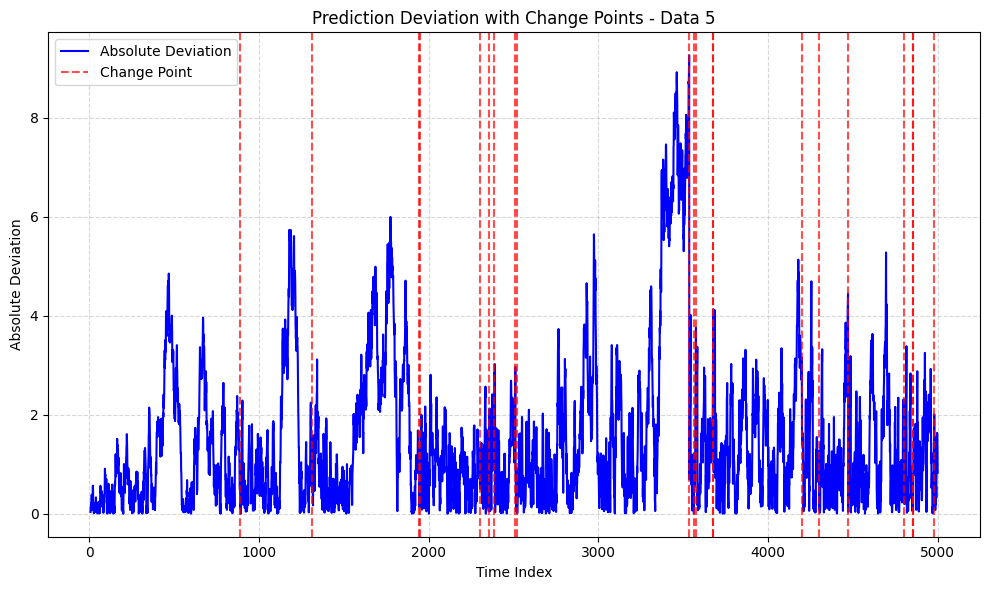

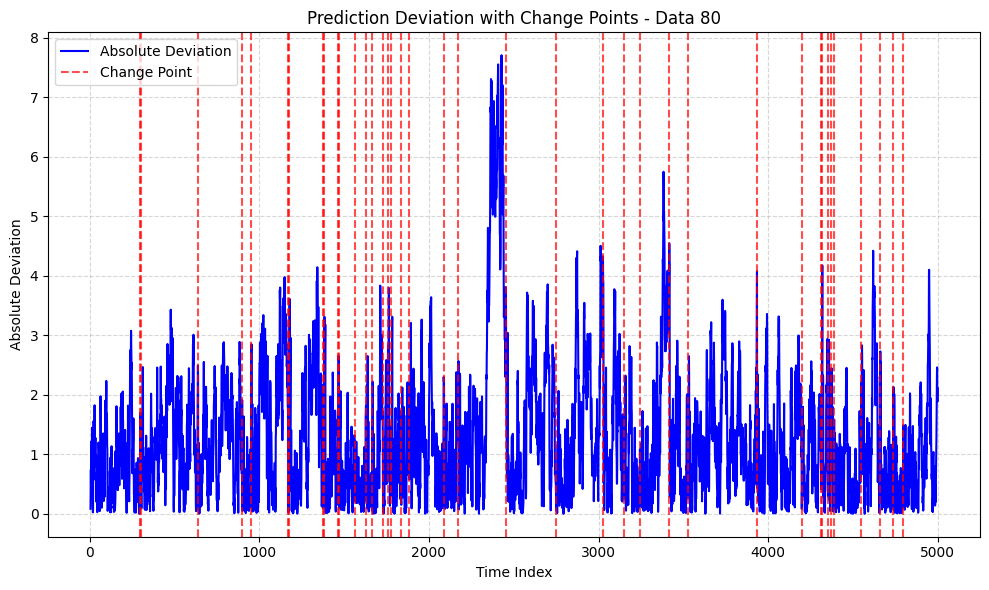

In [167]:
report_data1 = pd.read_csv('data/data_5_prediction_window_size_8.csv')
report_data2 = pd.read_csv('data/data_80_prediction_window_size_5.csv')

plot(report_data1,changepoints=False)
plot(report_data2,changepoints=False)
mse1 = np.mean((report_data1['prediction'] - report_data1['value'])**2)
mse2 = np.mean((report_data2['prediction'] - report_data2['value'])**2)
std1 = np.std(report_data1['prediction'])
std2 = np.std(report_data2['prediction'])
window_size1 = 8
window_size2 = 5
print('========report========')
print('window_size for data_5', window_size1)
print('window_size for data_80', window_size2)
print('data_5',report_data1['prediction'].describe())
print('data_80',report_data2.describe())
print('mse for data_5',mse1)
print('mse for data_80',mse2)
print('std for data_5',std1)
print('std for data_80',std2)


# Plot deviation for both datasets
plot_deviation_with_change_points(report_data1, 'Data 5')
plot_deviation_with_change_points(report_data2, 'Data 80')



threshold 0.9748936047287322
Number of MMD scores calculated: 4996
Threshold value: 0.9748936047287322
Number of change points detected: 155
155
[337, 472, 639, 776, 801, 956, 989, 1008, 1081, 1090, 1129, 1139, 1178, 1230, 1247, 1275, 1303, 1311, 1380, 1393, 1394, 1686, 1757, 1811, 1814, 1862, 1895, 1946, 1947, 1973, 2010, 2167, 2304, 2339, 2340, 2356, 2386, 2451, 2512, 2522, 2574, 2575, 2618, 2639, 2670, 2671, 2707, 2712, 2759, 2761, 2789, 2859, 2910, 2913, 2937, 2964, 2971, 2993, 3021, 3032, 3044, 3071, 3072, 3077, 3081, 3098, 3099, 3104, 3107, 3137, 3171, 3192, 3196, 3203, 3207, 3228, 3234, 3235, 3249, 3271, 3272, 3283, 3297, 3315, 3336, 3337, 3358, 3372, 3385, 3401, 3443, 3466, 3474, 3501, 3512, 3532, 3563, 3564, 3576, 3616, 3617, 3623, 3631, 3641, 3675, 3703, 3734, 3757, 3777, 3792, 3908, 3936, 4003, 4011, 4095, 4200, 4234, 4235, 4242, 4266, 4282, 4301, 4302, 4303, 4354, 4355, 4390, 4408, 4437, 4441, 4442, 4469, 4516, 4540, 4553, 4564, 4640, 4651, 4661, 4668, 4694, 4701, 4751, 476

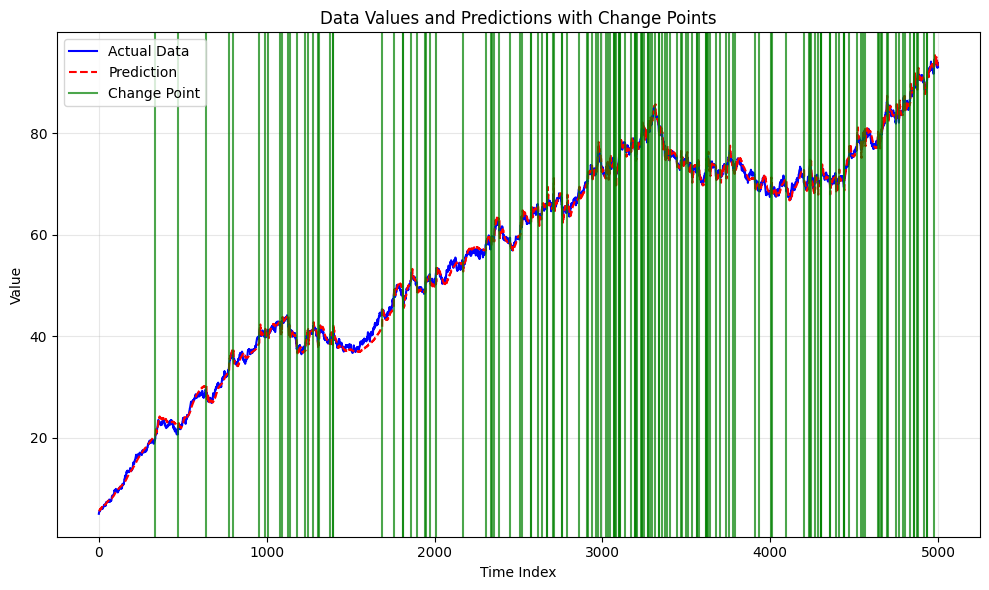

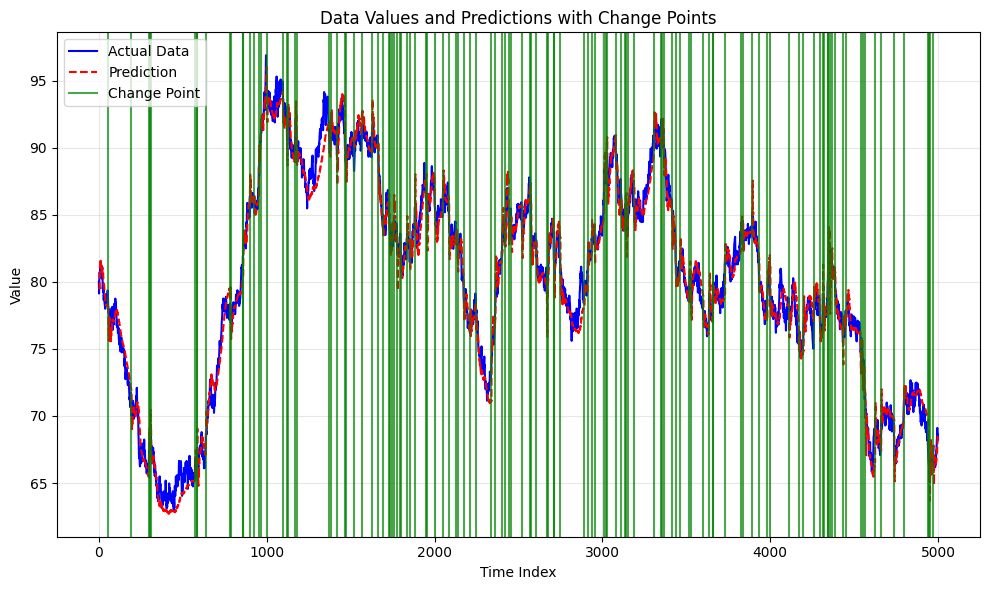

In [140]:

# Try different window size
window_size1 = 3
window_size2 = 3    
data_5 = pd.read_csv('data/data5.csv')
data_80 = pd.read_csv('data/data80.csv')
data_51 = prediction(data_5, window_size1)  
data_801 = prediction(data_80, window_size2)
data_801.to_csv('data/data_80_prediction_window_size_3.csv', index=False)
data_51.to_csv('data/data_5_prediction_window_size_3.csv', index=False)

plot(data_51)
plot(data_801)

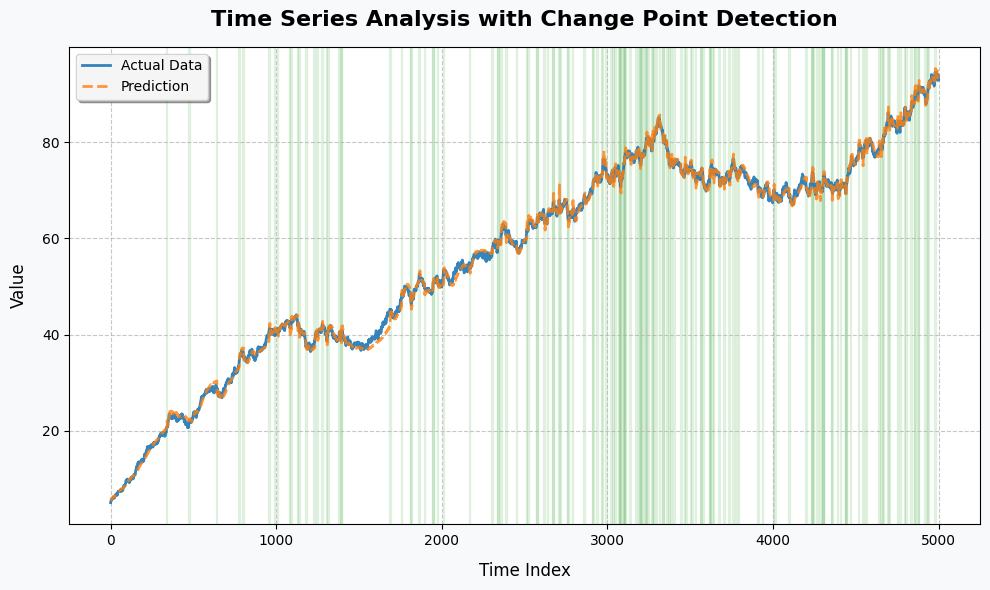

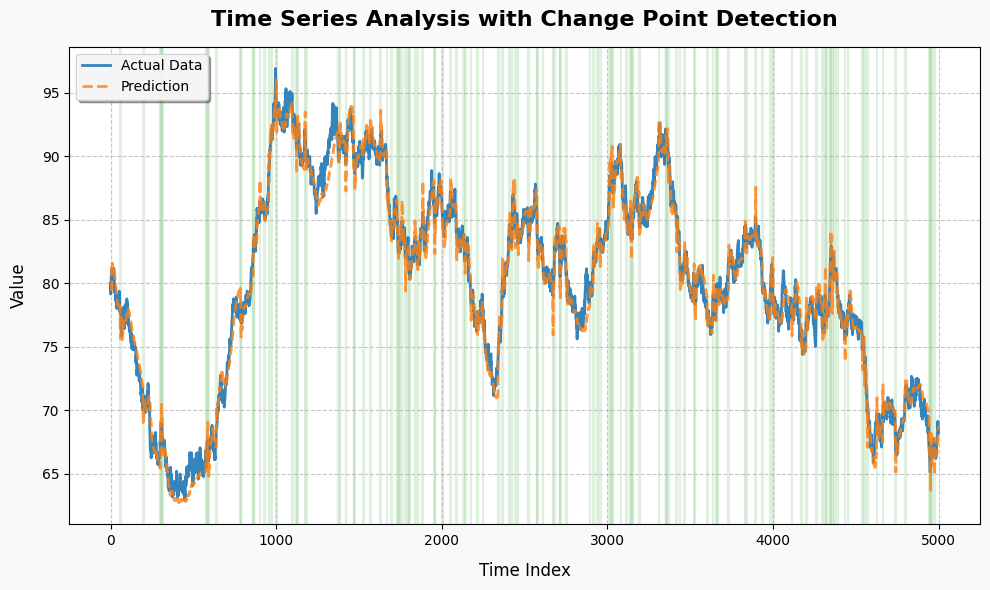

========report========
window_size for data_5 4
window_size for data_80 4
data_5 count    4998.000000
mean       56.124356
std        21.378845
min         5.499691
25%        38.904167
50%        62.366419
75%        73.047224
max        95.371232
Name: prediction, dtype: float64
data_80              value   time_index  change_point   prediction
count  5001.000000  5001.000000   5001.000000  4998.000000
mean     80.128728  2500.000000      0.025195    80.010523
std       7.686935  1443.808678      0.156733     7.729597
min      62.902754     0.000000      0.000000    62.705961
25%      76.321382  1250.000000      0.000000    76.222579
50%      80.499745  2500.000000      0.000000    80.487431
75%      85.615230  3750.000000      0.000000    85.684543
max      96.904312  5000.000000      1.000000    96.020109
mse for data_5 0.741533737976325
mse for data_80 1.040232282938866
std for data_5 21.376706029894137
std for data_80 7.728823398257863


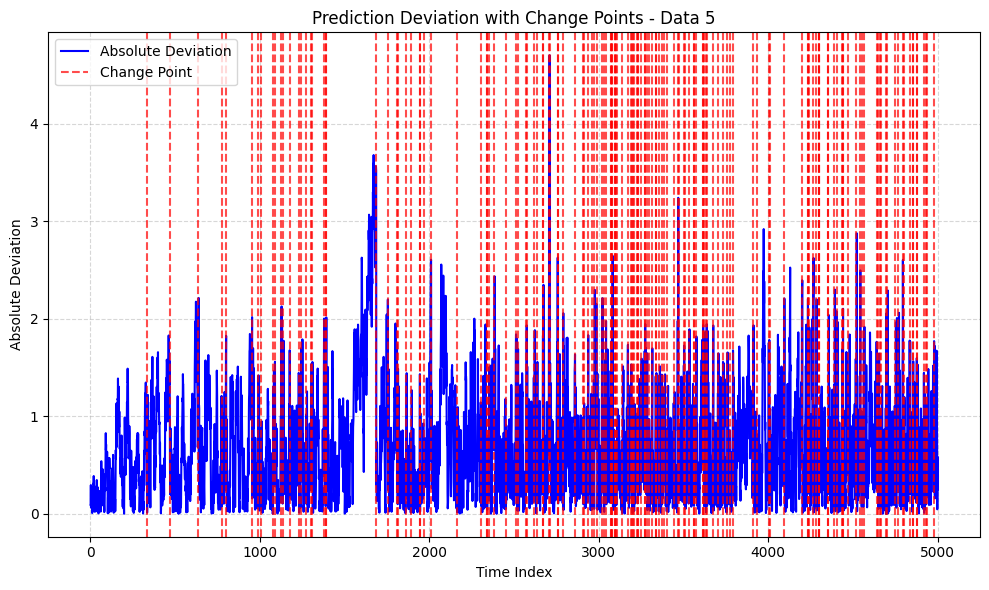

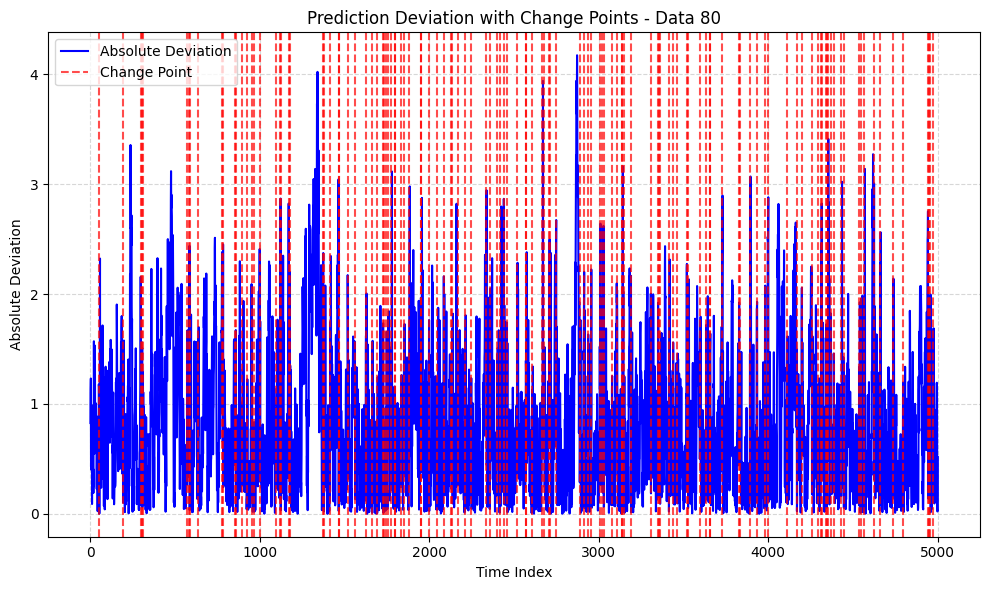

In [166]:
report_data1 = pd.read_csv('data/data_5_prediction_window_size_3.csv')
report_data2 = pd.read_csv('data/data_80_prediction_window_size_3.csv')

plot(report_data1,changepoints=False)
plot(report_data2,changepoints=False)
mse1 = np.mean((report_data1['prediction'] - report_data1['value'])**2)
mse2 = np.mean((report_data2['prediction'] - report_data2['value'])**2)
std1 = np.std(report_data1['prediction'])
std2 = np.std(report_data2['prediction'])

print('========report========')
print('window_size for data_5', window_size1)
print('window_size for data_80', window_size2)
print('data_5',report_data1['prediction'].describe())
print('data_80',report_data2.describe())
print('mse for data_5',mse1)
print('mse for data_80',mse2)
print('std for data_5',std1)
print('std for data_80',std2)


# Plot deviation for both datasets
plot_deviation_with_change_points(report_data1, 'Data 5')
plot_deviation_with_change_points(report_data2, 'Data 80')



In [163]:



# Try different window size
window_size1 = 4
window_size2 = 4    
data_5 = pd.read_csv('data/data5.csv')
data_80 = pd.read_csv('data/data80.csv')
data_51 = prediction(data_5,window_size1)
data_51.to_csv('data/data_5_prediction_window_size_4.csv', index=False)
data_801 = prediction(data_80,window_size2)
data_801.to_csv('data/data_80_prediction_window_size_4.csv', index=False)



threshold 1.0515763863507002
Number of MMD scores calculated: 4994
Threshold value: 1.0515763863507002
Number of change points detected: 101
101
[337, 639, 776, 956, 1178, 1230, 1275, 1303, 1311, 1393, 1394, 1757, 1946, 1947, 2130, 2304, 2340, 2356, 2386, 2451, 2511, 2512, 2522, 2574, 2575, 2670, 2671, 2707, 2761, 2789, 2913, 2937, 2993, 3021, 3044, 3071, 3072, 3077, 3098, 3099, 3107, 3137, 3196, 3207, 3228, 3234, 3249, 3271, 3272, 3297, 3315, 3336, 3358, 3372, 3443, 3466, 3532, 3563, 3564, 3576, 3617, 3623, 3641, 3675, 3734, 3757, 3777, 3908, 4003, 4011, 4095, 4200, 4234, 4242, 4266, 4282, 4301, 4302, 4354, 4355, 4390, 4408, 4437, 4441, 4442, 4469, 4516, 4553, 4564, 4640, 4661, 4694, 4751, 4794, 4803, 4835, 4855, 4879, 4919, 4933, 4977]
threshold 1.1284813497137052
Number of MMD scores calculated: 4994
Threshold value: 1.1284813497137052
Number of change points detected: 72
72
[194, 299, 304, 492, 573, 583, 637, 785, 899, 953, 1097, 1171, 1178, 1338, 1373, 1374, 1382, 1418, 1466, 1471

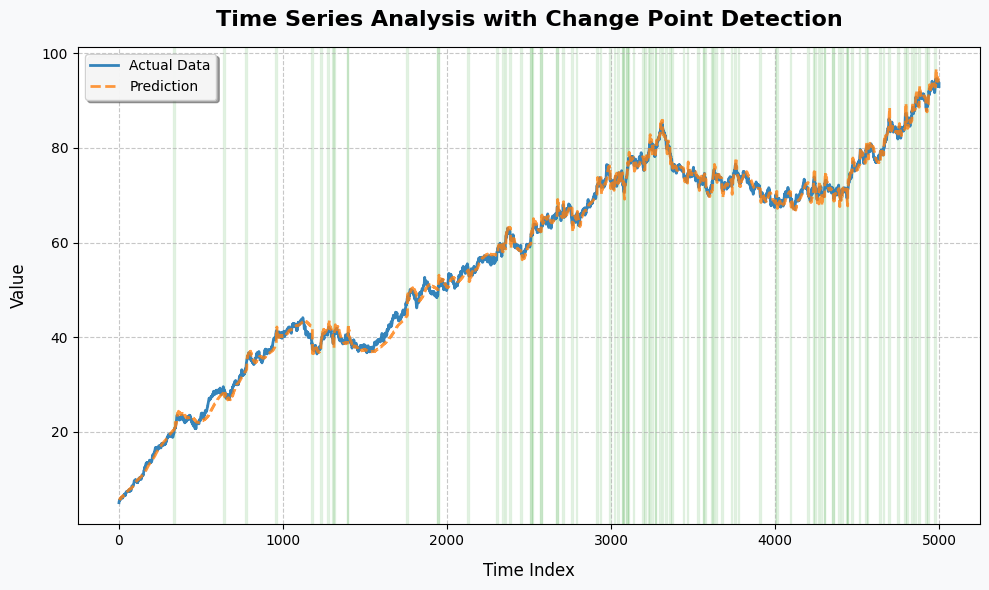

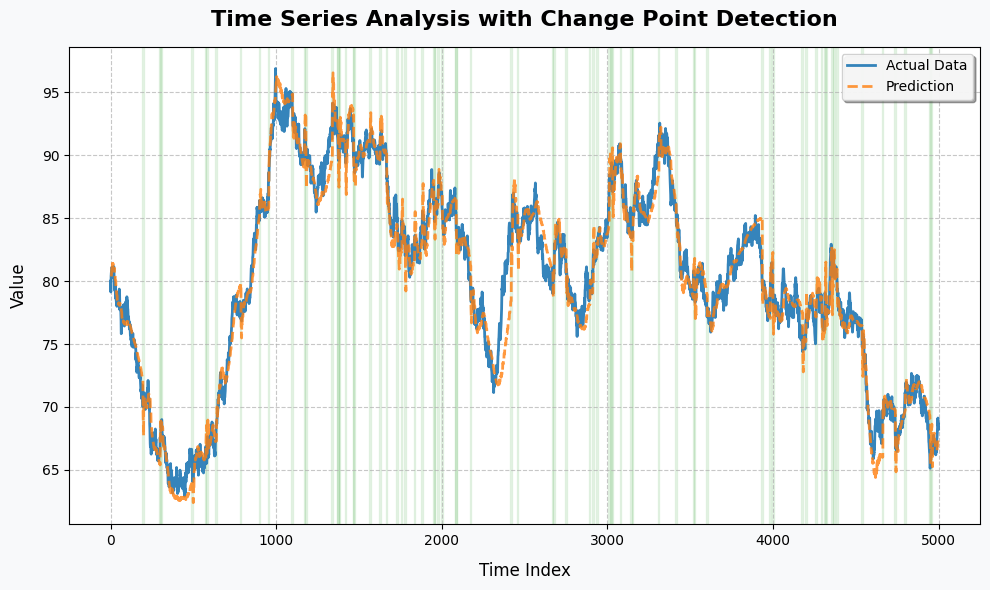

========report========
window_size for data_5 8
window_size for data_80 5
data_5 count    4996.000000
mean       56.059101
std        21.439623
min         5.563746
25%        38.891561
50%        62.308065
75%        73.161984
max        96.799875
Name: prediction, dtype: float64
data_80              value   time_index  change_point   prediction
count  5001.000000  5001.000000   5001.000000  4996.000000
mean     80.128728  2500.000000      0.014397    79.996356
std       7.686935  1443.808678      0.119133     7.829526
min      62.902754     0.000000      0.000000    62.382974
25%      76.321382  1250.000000      0.000000    76.074280
50%      80.499745  2500.000000      0.000000    80.299115
75%      85.615230  3750.000000      0.000000    85.553033
max      96.904312  5000.000000      1.000000    96.565776
mse for data_5 1.1252201755809321
mse for data_80 1.988364373076985
std for data_5 21.437477154086473
std for data_80 7.828742436979599


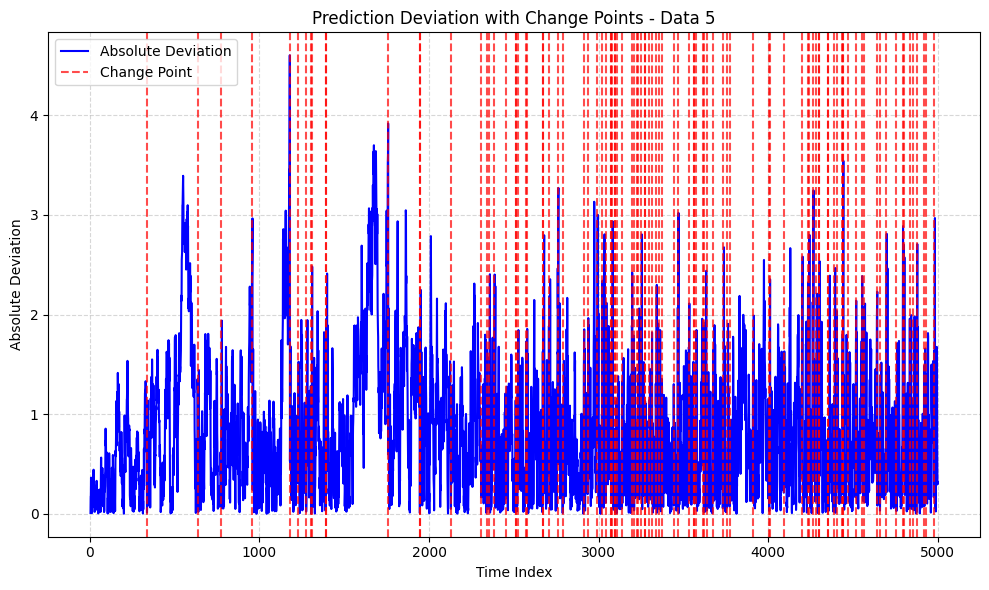

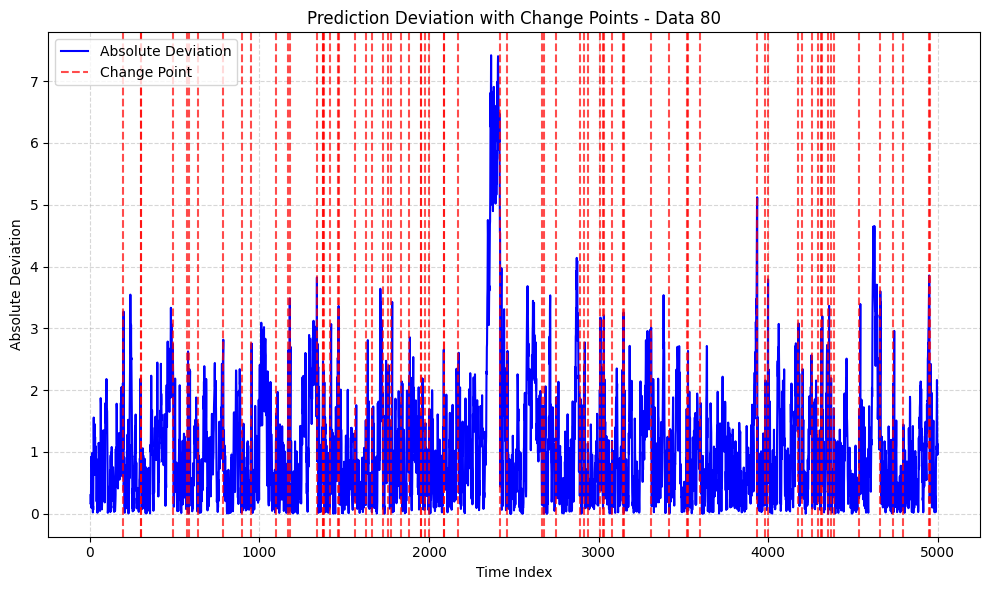

In [168]:
report_data1 = pd.read_csv('data/data_5_prediction_window_size_4.csv')
report_data2 = pd.read_csv('data/data_80_prediction_window_size_4.csv')

plot(report_data1,changepoints=False)
plot(report_data2,changepoints=False)
mse1 = np.mean((report_data1['prediction'] - report_data1['value'])**2)
mse2 = np.mean((report_data2['prediction'] - report_data2['value'])**2)
std1 = np.std(report_data1['prediction'])
std2 = np.std(report_data2['prediction'])

print('========report========')
print('window_size for data_5', window_size1)
print('window_size for data_80', window_size2)
print('data_5',report_data1['prediction'].describe())
print('data_80',report_data2.describe())
print('mse for data_5',mse1)
print('mse for data_80',mse2)
print('std for data_5',std1)
print('std for data_80',std2)


# Plot deviation for both datasets
plot_deviation_with_change_points(report_data1, 'Data 5')
plot_deviation_with_change_points(report_data2, 'Data 80')